**Advanced Machine Learning (Semester 1 2023)**
# 7 Autoencoders


*N. Hernitschek, 2023*


This Jupyter notebook gives an intro to Autoencoders.



---
## Contents
* [Autoencoders](#first-bullet)
* [Preparation for next time](#second-bullet)
* [Summary](#third-bullet)

## 1. Autoencoders<a class="anchor" id="second-bullet"></a>


*An autoencoder is a type of algorithm with the primary purpose of learning
an informative representation of the data that can be used for different
applications by learning to reconstruct a set of input observations well
enough.* 

D. Bank, N. Koenigstein & R. Giryes, https://arxiv.org/abs/2003.05991


Autoencoders are neural network trained in an unsupervised way to attempt to copy inputs to outputs - this is neither trivial nor pointless. In fact, Autoencoders are deep models capable of learning dense representations of the input. These representations are called **latent representations**.

An autoencoder has two distinct components :

*    An **encoder**: This part of the model takes the input data $\mathbf{x}$ and compresses it into the latent representation $\mathbf{h}$: $\mathbf{h} = f(W \mathbf{x}+\mathbf{b})$
    
*    A **decoder**: This part takes the latent representation $\mathbf{h}$ and tries to reconstruct the original input by mapping it back into the input space: $\tilde{x}= g(W'\mathbf{h}+\mathbf{c})$




The autoencoder’s architecture leads to a **dimensionality reduction**:


<img src="images/autoencoder.png?modified=12345678" width="600"/>



## 1.1 Example: PCA with an Autoencoder

We will use an autoencoder to project a 3-dimensional dataset into a 2-dimensional space by performing Principal Component Analysis. 

We first generate a 3D dataset:

In [8]:
import numpy as np
m = 300
data = np.empty((m, 3))
data[:, 0] = np.random.randn(m)*2
data[:, 1] = data[:,0] + (np.random.randn(m)/5)
data[:, 2] = data[:,0]**3 + data[:,1]**3 + 55#12
for i in range(data.shape[1]):
    data[:, i] = (data[:, i] - data[:, i].min()) / (data[:, i].max() - data[:, i].min())

Make a plot:

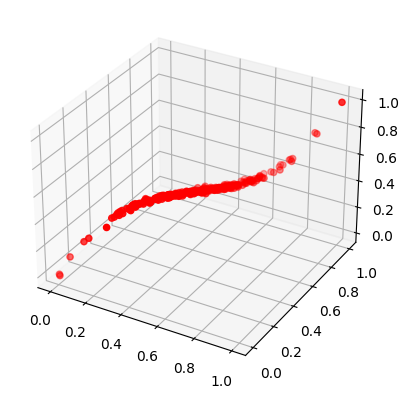

In [9]:
from mpl_toolkits import mplot3d

#Once this submodule is imported, a three-dimensional axes can be created by passing the 
#keyword projection='3d' to any of the normal axes creation routines:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points

ax.scatter3D(data[:, 0], data[:, 1], data[:, 2], c='red');


Now we have to create a Linear Autoencoder to perform PCA, which is done with the following code:

/home/nhernits/.local/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


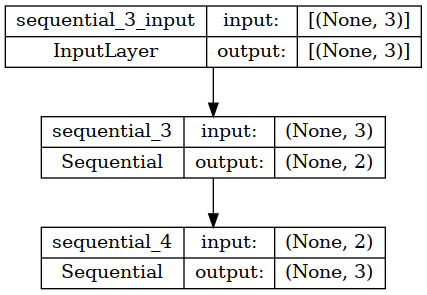

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import plot_model

encoder = Sequential([Dense(2, input_shape=[3])])
decoder = Sequential([Dense(3, input_shape=[2])])
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss="mse", optimizer=SGD(lr=0.01))
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

We now take a closer look at the code:
    
The first step is to define the encoder, a dense layer of 2 neurons that accepts inputs of dimension 3 
(we have a 3D dataset). Here we constrained the latent-space representation to be of dimension 2 (the output of the encoder).

The second step is to define the decoder, which is also a dense layer but now of 3 neurons as we want to reconstruct our 3-dimensional input at the output of the decoder.

The combination of the two - encoder and decoer - forms the Autoencoder.

After defining the network architecture, we have to train it using data as inputs and targets.

In [11]:
history = autoencoder.fit(data, data, epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6488
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 0.4007
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 0.2769
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.2047
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.1580
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.1263
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.1031
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.0856
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.0720
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0617


We see that the autoencoder is capable of finding the best 2D plane to project the data into while preserving as much variance as possible:

10/10 [==============================] - 0s 3ms/step


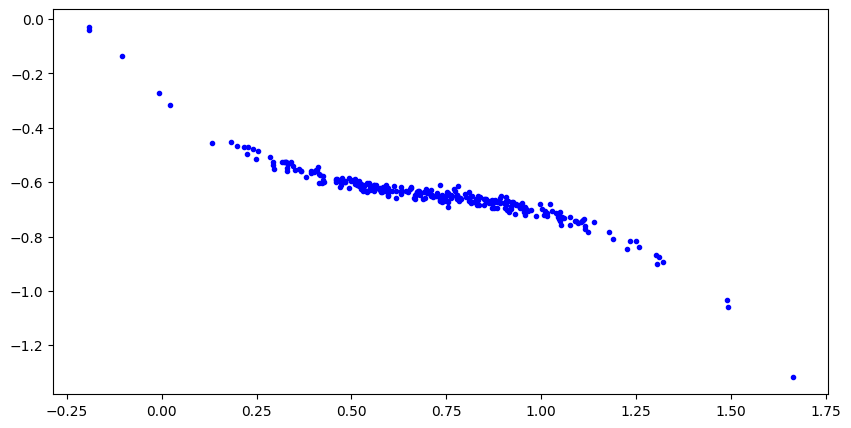

In [13]:
codings = encoder.predict(data)
fig = plt.figure(figsize=(10,5))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.show()

We see that the Autoencoder has reduced the dimensionality of our data in the same way as PCA would have done.

### 1.2 Example: Denoising Autoencoder

This is a more advanced example that demonstrates how to implement a deep convolutional autoencoder for image denoising, mapping noisy digits images from the MNIST dataset to clean digits images. This implementation is based on an original blog post titled *Building Autoencoders in Keras* by François Chollet.


In the case of **Denoising Autoencoders (DAE)**, the data is partially corrupted by noise added to the input vector. Then, the model is trained to predict the original, uncorrupted data as its output.



The training process is as follows:

*   An input is sampled from our dataset.
*   A corrupted version of this input is sampled from a stochastic mapping $M(\tilde{x}|x)$.
*   $(\tilde{x}|x)$ is used as a training example.

Just like regular AE, our DAE is a feedforward network that can be trained with a gradient-based approximate minimization on the negative log-likelihood.



<img src="images/denoising_schema.png?modified=1234eee56" width="800"/>


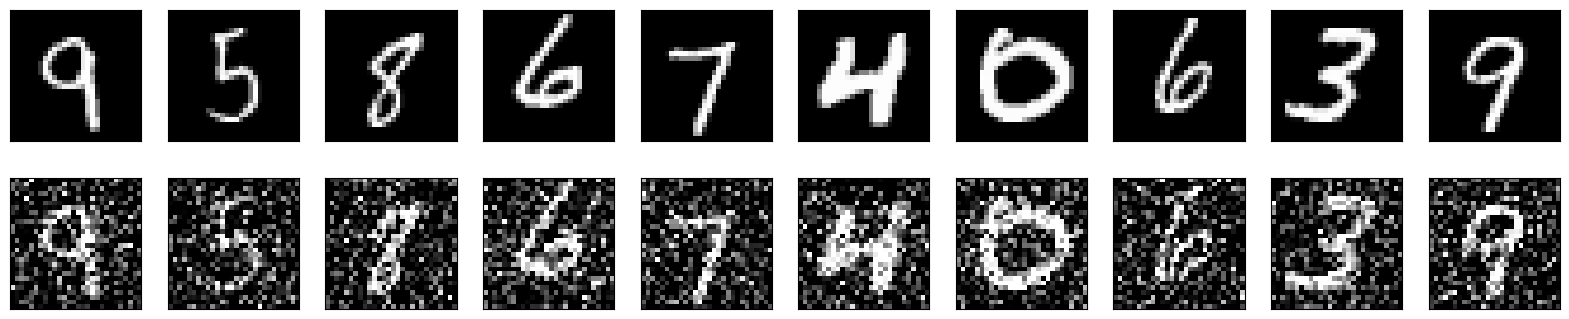

In [26]:
# Data preparation

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape)

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


# Since we only need images from the dataset to encode and decode, we're not using the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)




We are now using the Keras API to build our denoising autoencoder.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 32)       9248

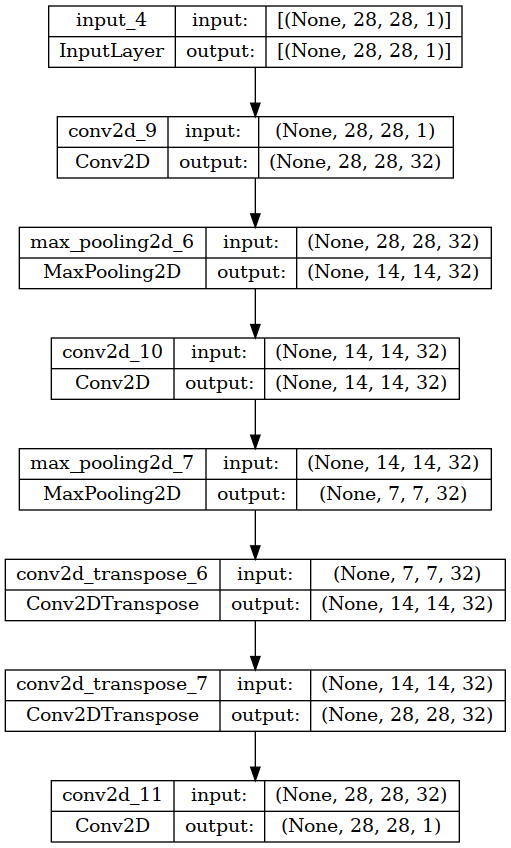

In [27]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

# plot the model

import pydot
import graphviz
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True, show_layer_names=True)


Now we can train our autoencoder using `train_data` as both our input data and target. We are setting up the validation data using the same format.

**Caution:** This takes a while. You can skip this for now and proceed with the predictions as I have included the pickled model in `autoencoder_model_saved.bin`.


In [23]:

import pickle


autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

with open("autoencoder_model.bin", "wb") as f:
  pickle.dump(autoencoder, f)


Epoch 1/50
469/469 [==============================] - 170s 362ms/step - loss: 0.0665 - val_loss: 0.0658
Epoch 2/50
469/469 [==============================] - 216s 460ms/step - loss: 0.0661 - val_loss: 0.0656
Epoch 3/50
469/469 [==============================] - 233s 497ms/step - loss: 0.0658 - val_loss: 0.0653
Epoch 4/50
469/469 [==============================] - 133s 283ms/step - loss: 0.0655 - val_loss: 0.0650
Epoch 5/50
469/469 [==============================] - 148s 316ms/step - loss: 0.0652 - val_loss: 0.0646
Epoch 6/50
469/469 [==============================] - 167s 356ms/step - loss: 0.0650 - val_loss: 0.0644
Epoch 7/50
469/469 [==============================] - 178s 380ms/step - loss: 0.0648 - val_loss: 0.0643
Epoch 8/50
469/469 [==============================] - 225s 481ms/step - loss: 0.0646 - val_loss: 0.0641
Epoch 9/50
469/469 [==============================] - 161s 343ms/step - loss: 0.0644 - val_loss: 0.0640
Epoch 10/50
469/469 [==============================] - 130s 276m

Let's predict on our test dataset and display the original image together with the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although not quite the same.

313/313 [==============================] - 11s 33ms/step


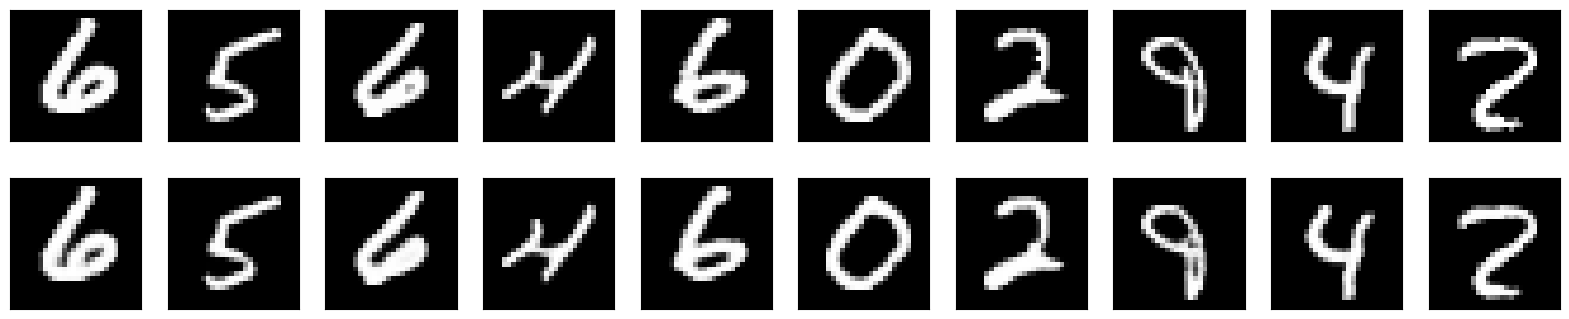

In [24]:

with open("autoencoder_model_saved.bin", "rb") as model:
  autoencoder = pickle.load(model)

predictions = autoencoder.predict(test_data)
display(test_data, predictions)


Now that we know that our autoencoder works, let's retrain it using the noisy data as our input and the clean data as our target. We want our autoencoder to learn how to denoise the images.


**Caution:** This takes a while. You can skip this for now and proceed with the predictions as I have included the pickled model in `denoising_autoencoder_model_saved.bin`.



In [28]:


autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)


with open("denoising_autoencoder_model.bin", "wb") as f:
  pickle.dump(autoencoder, f)


Epoch 1/100
469/469 [==============================] - 201s 427ms/step - loss: 0.1745 - val_loss: 0.1051
Epoch 2/100
469/469 [==============================] - 199s 425ms/step - loss: 0.1018 - val_loss: 0.0981
Epoch 3/100
469/469 [==============================] - 205s 437ms/step - loss: 0.0970 - val_loss: 0.0953
Epoch 4/100
469/469 [==============================] - 205s 437ms/step - loss: 0.0945 - val_loss: 0.0929
Epoch 5/100
469/469 [==============================] - 204s 434ms/step - loss: 0.0930 - val_loss: 0.0915
Epoch 6/100
469/469 [==============================] - 207s 442ms/step - loss: 0.0918 - val_loss: 0.0907
Epoch 7/100
469/469 [==============================] - 209s 446ms/step - loss: 0.0908 - val_loss: 0.0899
Epoch 8/100
469/469 [==============================] - 148s 316ms/step - loss: 0.0901 - val_loss: 0.0892
Epoch 9/100
469/469 [==============================] - 143s 304ms/step - loss: 0.0895 - val_loss: 0.0895
Epoch 10/100
469/469 [==============================] -



Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the input images.

313/313 [==============================] - 6s 19ms/step


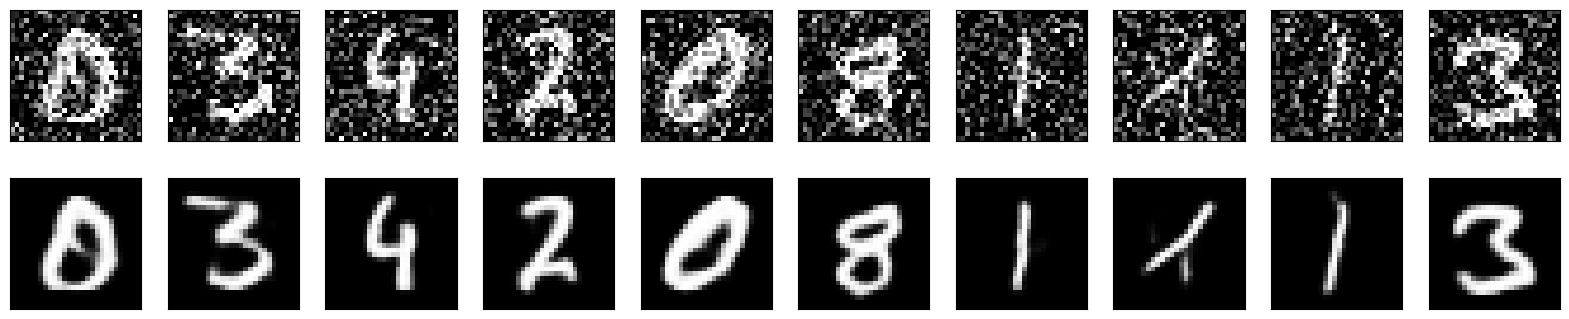

In [34]:

with open("denoising_autoencoder_model_saved.bin", "rb") as model:
  denoising_autoencoder = pickle.load(model)

predictions = denoising_autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)


### 1.3 Visualizing the Autoencoders

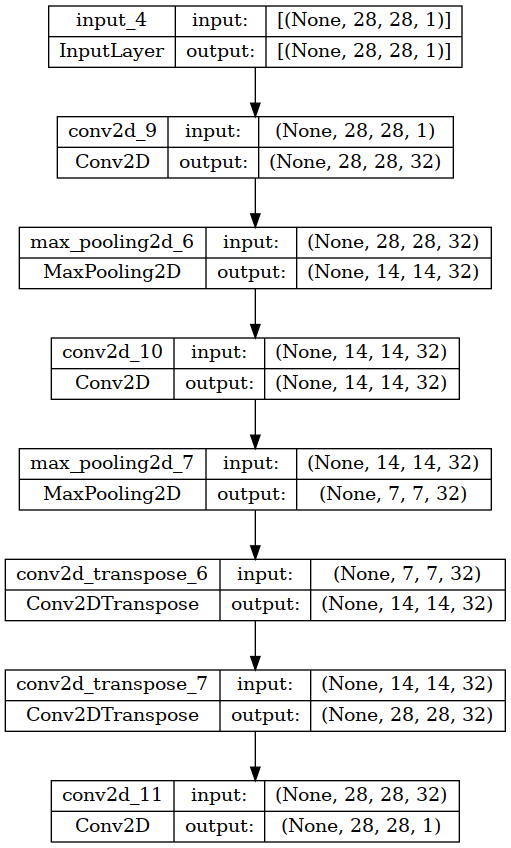

In [35]:

with open("autoencoder_model_saved.bin", "rb") as model:
  autoencoder = pickle.load(model)


import pydot
import graphviz
from keras.utils.vis_utils import plot_model

plot_model(autoencoder, to_file='autoencoder_plot.png', show_shapes=True, show_layer_names=True)


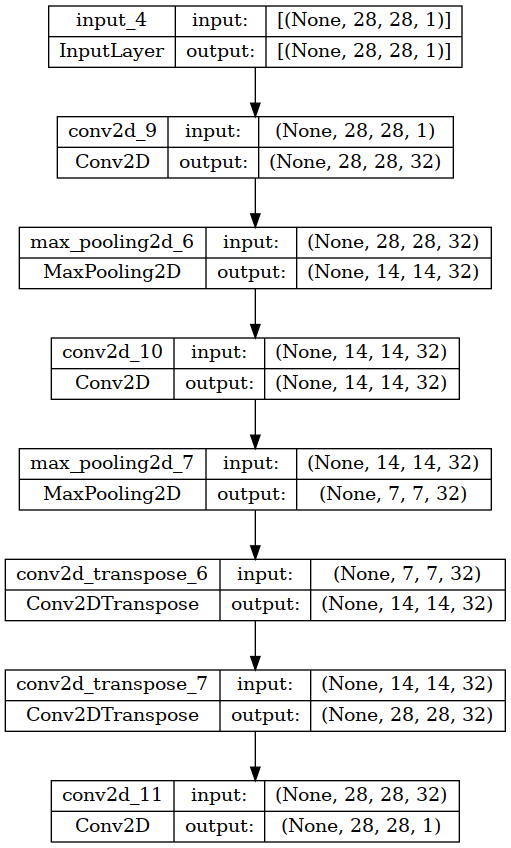

In [36]:

plot_model(denoising_autoencoder, to_file='denoising_autoencoder_plot.png', show_shapes=True, show_layer_names=True)

## 2. Preparation for next time<a class="anchor" id="fourth-bullet"></a>

On July 3 you will present your project status. In case you have any questions, please prepare them for discussion next time.

## 3. Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* seen how to use autoencoders with Keras
* seen an example of a denoising autoencoder.




